This model is based off of [this DINOv2 notebook example](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb)

# Loading in Data

Import Packages

In [2]:
from datasets import load_dataset
from PIL import Image
import os
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import torch
from patchify import patchify

/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


Load in the training data from huggingface

In [4]:
from datasets import load_dataset

dataset = load_dataset('saking3/alaska_dead_trees')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6400
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 653
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1286
    })
})

Data can be randomly subset to reduce training size in a similar manner as follows:

```
random_indices = np.random.choice(len(dataset["train"]), size=training_size, replace=False)
train_subset = dataset["train"].select(random_indices)

# Create a new DatasetDict with the subset
subset_training_dataset = DatasetDict({
    "train": train_subset,
    "validation": dataset["validation"],
    "test": dataset["test"]
})
```

Let's load the mappings between integers and their classes 

In [6]:
#get labels for each dataset 
id2label = {0: 'Background', 1: 'Dead Tree'}

### Create a a PyTorch dataset 

We create a regular PyTorch dataset, which prepares the examples for the model. We augment the training images by random resizing and cropping them to a fixed resolution (448x448), and normalize the color channels. This way, all our training images will have the same fixed resolution. Here we use the Albumentations library for that purpose, but note that one can also use other libraries like Torchvision or Kornia.

Note that the model will expect pixel_values of shape (batch_size, num_channels, height, width) as input. As Albumentations works on NumPy arrays (which uses a channels-last format), we make sure that the channels are first. The labels which the model also expects are of shape (batch_size, height, width) and indicate the ground truth label per pixel, for every example in the batch.

In [7]:
class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    original_image = np.array(item["image"])
    original_segmentation_map = np.array(item["label"])

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])

    # convert to C, H, W
    image = image.permute(2,0,1)

    return image, target, original_image, original_segmentation_map

**Transformations:** We augment the training images by random resizing and cropping them to a fixed resolution (448x448), and normalize the color channels. This way, all our training images will have the same fixed resolution.

**Resize:** Neural networks typically require a fixed input size for images. Resizing transformations ensure that 
images fed into the model have consistent dimensions, making it possible to batch process them efficiently.

**Normalize:** Standardize Input Data: Normalization ensures that the pixel values of the images are scaled to a 
standard range (commonly mean of 0 and standard deviation of 1). This helps with the convergence of the 
training process because it standardizes the input distribution.

**Flip:** Transformations such as random cropping, rotation, flipping, and color jittering create variations of the training images. This helps the model generalize better by seeing many different versions of the same images, reducing overfitting.

In [8]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(),
    A.Normalize(mean=(0.5,), std=(0.5,)),
])

val_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.Normalize(mean=ADE_MEAN.tolist(), std=ADE_STD.tolist()),
])

Making and loading datasets

In [9]:
# Create datasets
train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["validation"], transform=val_transform)
test_dataset = SegmentationDataset(dataset["test"], transform=val_transform)

Check the number of samples in each dataset, and test and load an image from a dataset in to check that everything looks right. 

In [10]:
print("Number of train images:", len(train_dataset))
print("Number of val images:", len(val_dataset))
print("Number of test images:", len(test_dataset))

Number of train images: 6400
Number of val images: 653
Number of test images: 1286


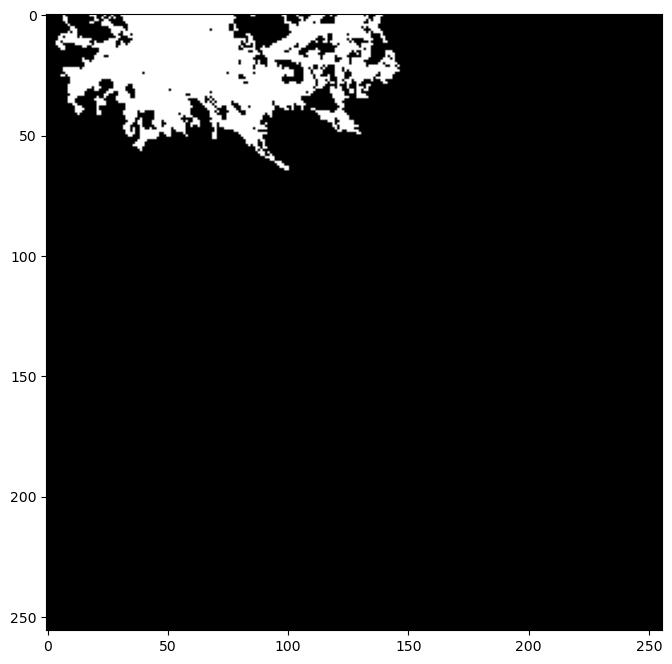

In [33]:
img, targ, orig_img, orig_label = val_dataset[300]
orig = Image.fromarray(orig_label)
figure = plt.figure(figsize=(8, 8))
plt.imshow(orig_label.squeeze(), cmap="gray")

Note that the model will expect pixel_values of shape (batch_size, num_channels, height, width) as input. As Albumentations works on NumPy arrays (which uses a channels-last format), we make sure that the channels are first. The labels which the model also expects are of shape (batch_size, height, width) and indicate the ground truth label per pixel, for every example in the batch.

In [34]:
pixel_values, target, original_image, original_segmentation_map = train_dataset[3]
print(pixel_values.shape)
print(target.shape)

torch.Size([3, 448, 448])
torch.Size([448, 448])


In [22]:
pixel_values, target, original_image, original_segmentation_map = val_dataset[3]
print(pixel_values.shape)
print(target.shape)
print(original_image.shape)
print(original_segmentation_map.shape)

torch.Size([3, 448, 448])
torch.Size([448, 448])
(256, 256, 3)
(256, 256)


### Create PyTorch Dataloaders

Next, we create PyTorch dataloaders, which allow us to get batches of data (as neural networks are trained on batches using stochastic gradient descent or SGD). We just stack the various images and labels along a new batch dimension.

In [35]:
def collate_fn(inputs):
    batch = dict()
    pixel_values = torch.stack([torch.tensor(i[0]).float() for i in inputs], dim=0)
    labels = torch.stack([torch.tensor(i[1]).long() for i in inputs], dim=0)
    original_images = [torch.tensor(i[2]).float() for i in inputs]
    original_segmentation_maps = [torch.tensor(i[3]).long() for i in inputs]

    # Uncomment this if your pixel_values are in (batch_size, height, width, channels) format
    # pixel_values = pixel_values.permute(0, 3, 1, 2)

    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    batch["original_images"] = original_images
    batch["original_segmentation_maps"] = original_segmentation_maps

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

Let's check a batch:

In [36]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([4, 3, 448, 448])
labels torch.Size([4, 448, 448])


/tmp/ipykernel_973576/2434633893.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.stack([torch.tensor(i[0]).float() for i in inputs], dim=0)
/tmp/ipykernel_973576/2434633893.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(i[1]).long() for i in inputs], dim=0)


Note that the pixel values are float32 tensors, whereas the labels are long tensors:

In [19]:
batch["pixel_values"].dtype

torch.float32

In [18]:
batch["labels"].dtype

torch.int64

### Creating weights for the dataset 

The amount of background is much larger relative to dead trees. Weighting the dataset will penalize misclassifications of dead trees more than that of the background. The hope is that this makes the model better at identifying dead trees.

In [13]:
from collections import Counter

def count_pixels_in_masks(dataset):
    label_counts = Counter()

    # Create a DataLoader to iterate through the dataset
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    for _, mask, _, _ in data_loader:
        # Flatten the mask to count the occurrences of each class
        mask_flattened = mask.numpy().flatten()
        label_counts.update(mask_flattened)

    return label_counts

# Assuming train_dataset is already defined
label_counts = count_pixels_in_masks(train_dataset)

print("Class distribution:", label_counts)

Class distribution: Counter({0: 1144758787, 1: 139746813})


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# New class distribution from the function
class_distribution = Counter({0: 1144758787, 1: 139746813})

# Total number of pixels
total_pixels = sum(class_distribution.values())

# Calculate weights
weight_background = total_pixels / (2 * class_distribution[0])
weight_foreground = total_pixels / (2 * class_distribution[1])

# Create class weights tensor
class_weights = torch.tensor([weight_background, weight_foreground]).to(device)

print("Class weights:", class_weights)
class_weights = torch.tensor([weight_background, weight_foreground]).to(device)

Class weights: tensor([0.5610, 4.5958], device='cuda:0')


# Training the Model

### the DINOv2 Model and Linear Classifier Functions

The model is basically structured as a [DINOv2 as backbone + a linear classifier on top](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb). 

**The Dino Model:** Leverages the DINOv2 model for semantic segmentation. This involves taking an input image, processing it through the DINOv2 model to obtain feature embeddings, and then applying a classifier to generate segmentation masks (feature embeddings = high-dimensional vectors that capture the essential characteristics of your data, usually extracted by deep learning models. They're needed to do downstream tasks, like segmentation). 

**The Linear Classifier:** The LinearClassifier converts the high-dimensional feature embeddings from the DINOv2 model into class logits for each pixel in the input images (class logits = a likelihood that a pixel is a certain class. eg. a dead tree or not a dead tree).

This is achieved by:
- Reshaping the flattened embeddings back into a spatial format.
- Applying a 1x1 convolution to produce the final class logits (a 1x1 convolutional layer is equivalent to a linear transformation).

In [15]:
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
    def __init__(self, config, class_weights=None):
        """
        Initialize the DINOv2 model for semantic segmentation.

        Args:
        - config: Configuration object containing model parameters.
        - class_weights: Tensor containing class weights for the loss function.
        """
        super().__init__(config)
        self.dinov2 = Dinov2Model(config)  # Load the base DINOv2 model
        self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)  # Define the classification head
        self.class_weights = class_weights  # Store class weights

    def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
        """
        Forward pass for the semantic segmentation model.

        Args:
        - pixel_values: Tensor of shape (batch_size, num_channels, height, width) containing input images.
        - output_hidden_states: If True, return hidden states.
        - output_attentions: If True, return attention weights.
        - labels: Tensor of shape (batch_size, height, width) containing segmentation maps (optional).

        Returns:
        - SemanticSegmenterOutput containing:
          - loss: Cross-entropy loss (if labels are provided).
          - logits: Tensor of shape (batch_size, num_labels, height, width) containing class logits.
          - hidden_states: List of hidden states from the DINOv2 model (if output_hidden_states is True).
          - attentions: List of attention weights from the DINOv2 model (if output_attentions is True).
        """
        # Obtain DINOv2 model outputs
        outputs = self.dinov2(pixel_values, output_hidden_states=output_hidden_states, output_attentions=output_attentions)
        
        # Extract patch embeddings (excluding the CLS token)
        patch_embeddings = outputs.last_hidden_state[:, 1:, :]
        
        # Check the shape of patch_embeddings
        batch_size, num_patches, embedding_dim = patch_embeddings.shape
        #print(f"patch_embeddings shape: {patch_embeddings.shape}")

        # Calculate the expected number of patches
        num_patches_expected = self.classifier.width * self.classifier.height
        if num_patches != num_patches_expected:
            raise ValueError(f"Unexpected number of patches: {num_patches}, expected: {num_patches_expected}")

        # Apply the classification head to the patch embeddings
        logits = self.classifier(patch_embeddings)
        
        # Resize logits to match the size of the input images
        logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)
        
        # Initialize loss to None
        loss = None
        if labels is not None:
            # Compute the cross-entropy loss with class weights
            #loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights, ignore_index=0)  # Use 0 as the ignore index for background

            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits, labels)
        
        # Return the output containing the loss, logits, hidden states, and attentions
        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [16]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)

We can instantiate the model as follows:

In [17]:
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", 
                                                      id2label=id2label, num_labels=len(id2label))

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting param.requires_grad = True enables the dinov2 layers to have their parameters updated (fine-tuned) during model training. In theory this should provide better results. If we set param.requires_grad = False, then the original dinov2 parameters are frozen and will not be updated during training.

In [42]:
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = True

Before running the entire model, we can perform a forward pass on a random batch, to verify the shape of the logits and verify we can calculate a loss:

In [43]:
outputs = model(pixel_values=batch["pixel_values"], labels=batch["labels"])
print(outputs.logits.shape)
print(outputs.loss)

torch.Size([4, 2, 448, 448])
tensor(0.4449, grad_fn=<NllLoss2DBackward0>)


### Training the Model

We'll train the model in regular PyTorch fashion. We also use the mIoU (mean Intersection-over-Union) metric to evaluate the performance during training.

In [44]:
import evaluate

metric = evaluate.load("mean_iou")

Check that we are running this on cuda (although we defined the device earlier when calculating weights for the model

In [45]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Depending on the number of cuda devices available to you, which can be checked via: `print(torch.cuda.device_count())`

You can parallelize the model across multiple devices by setting the initial device to:
`device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")` 

Then setting the model to run in parallel across multiple devices with nn.DataParallel()
```
import torch.nn as nn
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model.to(device)
```

Setting parameters (learning rate and epochs) for the model and picking our gradient descent method (I am using AdamW), then push the model to device. 

In [46]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 1e-6
epochs = 1

optimizer = AdamW(model.parameters(), lr=learning_rate)

# put model on GPU (set runtime to GPU in Google Colab)
#device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Dinov2ForSemanticSegmentation(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
      

Train the model. It's set to print stats per 500 batches. 

In [47]:
# put model in training mode
model.train()

for epoch in range(epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      # evaluate
      with torch.no_grad():
        predicted = outputs.logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # let's print loss and metrics every 500 batches
      if idx % 500 == 0:
        metrics = metric.compute(num_labels=len(id2label),
                                ignore_index=0,
                                reduce_labels=False,
        )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/1600 [00:00<?, ?it/s]/tmp/ipykernel_973576/2434633893.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.stack([torch.tensor(i[0]).float() for i in inputs], dim=0)
/tmp/ipykernel_973576/2434633893.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(i[1]).long() for i in inputs], dim=0)
/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/sking11/.cache/huggingface/modules/evaluate_modul

Loss: 0.42751219868659973
Mean_iou: 0.18364918250002044
Mean accuracy: 0.36729836500004087


 31%|███▏      | 501/1600 [03:18<1:03:13,  3.45s/it]

Loss: 0.2982217073440552
Mean_iou: 0.3104872926125582
Mean accuracy: 0.6209745852251164


 63%|██████▎   | 1001/1600 [06:27<37:54,  3.80s/it] 

Loss: 0.0751984491944313
Mean_iou: 0.3235982077732422
Mean accuracy: 0.6471964155464844


 94%|█████████▍| 1501/1600 [09:36<05:43,  3.47s/it]

Loss: 0.09493467956781387
Mean_iou: 0.3449354485749551
Mean accuracy: 0.6898708971499102


100%|██████████| 1600/1600 [10:11<00:00,  2.62it/s]


Save the trained model so it can be used to run predictions.

In [31]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), '/explore/nobackup/people/sking11/dinov2_model_checkpoint.pth')
torch.save(model, '/explore/nobackup/people/sking11/dinov2model.pth')

# Performing Inference on single tile for dataset

Let's first load in the model

In [18]:
# Load the complete model
model = torch.load('/explore/nobackup/people/sking11/dinov2model_6400.pth')
model.to(device)

/tmp/ipykernel_1647331/219873635.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/explore/nobackup/people/sking11/dinov2model_6400.pth')


Dinov2ForSemanticSegmentation(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
      

Here we load in an image, convert the image to a tensor, ensure the values are in the correct order, and check the shape of the converted tensor, the transformed validation image and the original/raw image. 

In [19]:
val_image, _, original_image, _ = val_dataset[300] #change image by changing index value
pixel_values = val_image
pixel_values = torch.tensor(pixel_values)  # Assuming this gives you the transformed image
pixel_values = pixel_values.permute(0, 1, 2).unsqueeze(0)  # Convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)  # Check the shape to verify it's [1, 3, height, width]
print(val_image.shape)
print(original_image.shape)

torch.Size([1, 3, 448, 448])
torch.Size([3, 448, 448])
(256, 256, 3)


/tmp/ipykernel_1647331/2600473792.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(pixel_values)  # Assuming this gives you the transformed image


Run a forward pass through the model with our image (that has been converted to a tensor). 

In [52]:
# Forward pass through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(pixel_values.to(device))

In [53]:
# Upsample the logits to match the size of the input image
upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=original_image.shape[:2],
                                                   mode="bilinear", align_corners=False)

In [54]:
# Get the predicted segmentation map
predicted_map = upsampled_logits.argmax(dim=1)

This function takes an image + segmentation map pair and plots the segmentation map over the image in a semi-transparent layer. You can use this to view things like predicted segmentation maps. 

In [55]:
# map every label to a random color
id2color = {k: list(np.random.choice(range(256), size=3)) for k, v in id2label.items()}

#function that plots the labeled masks (colored according to id2color) as a transparent layer
#over the original image
def visualize_map(image, segmentation_map):
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        color_seg[segmentation_map == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

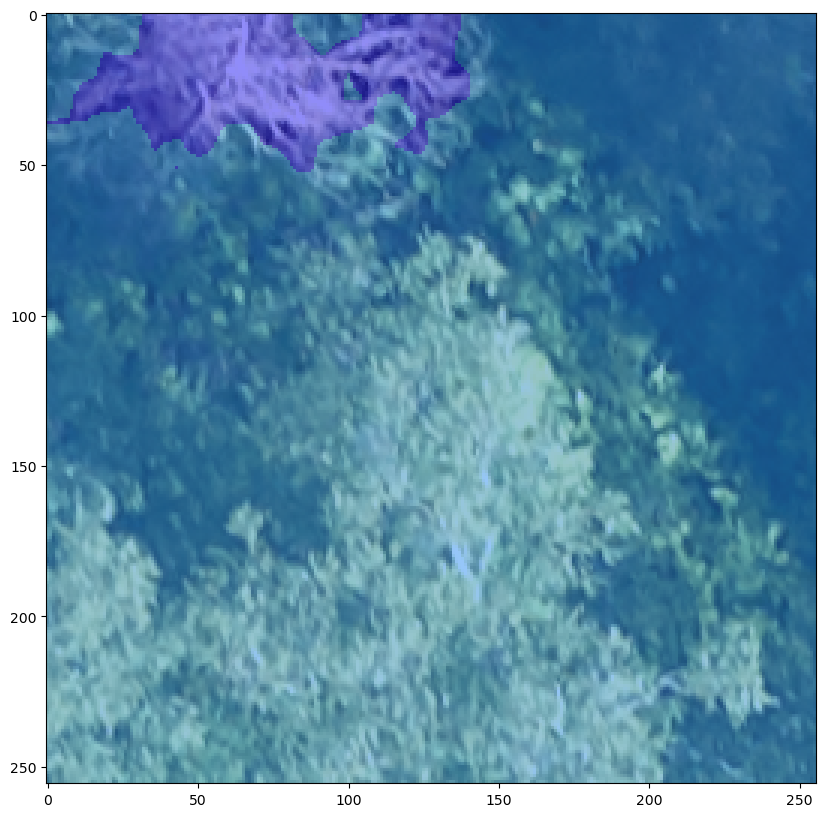

In [56]:
# Visualize the segmentation map
visualize_map(original_image, predicted_map.squeeze().cpu())

# Running Model Statistics using our evaluation dataset

In order to run model statistics, we need to first get predictions for a validation/test dataset of images. The following block will run model predictions on an entire set of images and save them to a numpy list and as PIL images in an output folder of your choosing.

In [30]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm

# Directory to save predicted masks
output_dir = "/explore/nobackup/people/sking11/DINOoutputmasks" #change to your desired output directory

# List to store all predicted masks
predicted_masks_list = []

# Ensure the model is in evaluation mode
model.eval()

# Loop through each image in the validation dataset
for idx in tqdm(range(len(val_dataset))):
    val_image, _, original_image, _ = val_dataset[idx]
    
    # Convert the image to a tensor and add a batch dimension
    pixel_values = torch.tensor(val_image).permute(0, 1, 2).unsqueeze(0).to(device)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(pixel_values)
    
    # Upsample the logits to match the original image size
    upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                       size=original_image.shape[:2],
                                                       mode="bilinear", align_corners=False)
    
    # Get the predicted segmentation map
    predicted_map = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    
    # Save the predicted map in the list
    predicted_masks_list.append(predicted_map)
    
    # Convert predicted map to an image (you may need to normalize the values)
    predicted_image = Image.fromarray((predicted_map * 255).astype(np.uint8))
    
    # Save the predicted image
    output_path = os.path.join(output_dir, f"predicted_mask_{idx}.png")
    predicted_image.save(output_path)

    #print(f"Processed image {idx + 1}/{len(val_dataset)}")

print("All images processed and saved.")

# Now, `predicted_masks_list` contains all the predicted masks

  0%|          | 0/653 [00:00<?, ?it/s]/tmp/ipykernel_1647331/538942418.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(val_image).permute(0, 1, 2).unsqueeze(0).to(device)
100%|██████████| 653/653 [00:31<00:00, 20.92it/s]

All images processed and saved.


In [31]:
#checking length and shape of our predicted masks 
print(f"Number of patches in the list: {len(predicted_masks_list)}")
print(f"Size of patch: {predicted_masks_list[3].shape}")

Number of patches in the list: 653
Size of patch: (256, 256)


### Confusion Matrix

First we extract the original masks, then we compare them to the predicted masks to calculate confusion matrix. 

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize an empty list to store binary masks
val_binary_masks = []

# Iterate over the validation dataset to extract binary masks
for idx in range(len(val_dataset)):
    _, target, _, original_segmentation_map = val_dataset[idx]
    # Directly use the original segmentation map if it's already binary
    binary_mask = original_segmentation_map.squeeze()
    val_binary_masks.append(binary_mask)

assert len(val_binary_masks) == len(predicted_masks_list)

# Flatten all masks and concatenate them into single arrays
actual_flat = np.concatenate([mask.flatten() for mask in val_binary_masks])
predicted_flat = np.concatenate([mask.flatten() for mask in predicted_masks_list])

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actual_flat, predicted_flat)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[39349079   533588]
 [  441885  2470456]]


### Mean IOU

In [33]:
import numpy as np

def calculate_iou(predicted_mask, actual_mask):
    # Ensure the masks are binary (0 and 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    actual_mask = (actual_mask > 0.5).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(predicted_mask, actual_mask)
    union = np.logical_or(predicted_mask, actual_mask)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_mean_iou(predicted_masks, actual_masks):
    ious = []

    for pred, actual in zip(predicted_masks, actual_masks):
        iou = calculate_iou(pred, actual)
        ious.append(iou)

    mean_iou = np.mean(ious)
    return mean_iou

mean_iou = calculate_mean_iou(predicted_masks_list, val_binary_masks)
print(f"Mean IoU: {mean_iou:.4f}")

Mean IoU: 0.6069


### Mean accuracy and Per Pixel Accuracy

Per pixel accuracy calculates the ratio of correctly predicted pixels to the total number of pixels.
Mean accuracy calculates the average accuracy across all images in the validation set.

In [34]:
import numpy as np

def calculate_accuracies(val_binary_masks, predicted_masks_list):
    assert len(val_binary_masks) == len(predicted_masks_list), "Mismatch in the number of masks."

    total_pixels = 0
    correct_pixels = 0
    accuracies = []

    for actual_mask, predicted_mask in zip(val_binary_masks, predicted_masks_list):
        # Ensure masks have the same shape
        assert actual_mask.shape == predicted_mask.shape, "Mismatch in mask dimensions."
        
        # Flatten the masks to simplify the accuracy calculation
        actual_flat = actual_mask.flatten()
        predicted_flat = predicted_mask.flatten()
        
        # Calculate the number of correct predictions for the current mask
        correct = np.sum(actual_flat == predicted_flat)
        
        # Calculate per-pixel accuracy for the current mask
        accuracy = correct / len(actual_flat)
        accuracies.append(accuracy)
        
        # Update total pixels and correct pixels
        total_pixels += len(actual_flat)
        correct_pixels += correct

    # Mean accuracy across all images
    mean_accuracy = np.mean(accuracies)

    # Per-pixel accuracy
    per_pixel_accuracy = correct_pixels / total_pixels

    return mean_accuracy, per_pixel_accuracy

mean_accuracy, per_pixel_accuracy = calculate_accuracies(val_binary_masks, predicted_masks_list)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Per-Pixel Accuracy: {per_pixel_accuracy:.4f}")

Mean Accuracy: 0.9772
Per-Pixel Accuracy: 0.9772


### Variation in Accuracy

Looks at accuracy for each tile in validation dataset and compares the variation in accuracy across all images

In [ ]:
# Calculate accuracy for each tile
accuracies = []
for actual_mask, predicted_mask in zip(val_binary_masks, predicted_masks_list):
    # Ensure both masks have the same shape
    assert actual_mask.shape == predicted_mask.shape, "Mismatch in mask shapes"
    
    # Calculate the number of correctly predicted pixels
    correct_pixels = np.sum(actual_mask == predicted_mask)
    total_pixels = actual_mask.size
    accuracy = correct_pixels / total_pixels
    
    accuracies.append(accuracy)

# Now, accuracies contains the accuracy for each tile

#this statement prints all the accuracies for your viewing. 
for idx, acc in enumerate(accuracies):
    print(f"Tile {idx}: Accuracy = {acc:.4f}")

Save accuracies to a csv for future ref 

In [ ]:
import csv

# Specify the full file path
file_path = '/explore/nobackup/people/sking11/DINO_accuracies.csv'

# Save as CSV using csv module
with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Tile', 'Accuracy'])  # Write the header
    for idx, accuracy in enumerate(accuracies):
        writer.writerow([idx, accuracy])

Plot the accuracies

In [ ]:
import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(accuracies, vert=True, patch_artist=True)

# Adding titles and labels
plt.title('Distribution of Tile Accuracies')
plt.xlabel('Tiles')
plt.ylabel('Accuracy')

# Optional: Customize the plot
plt.xticks([1], ['Tile Accuracies'])  # Since there's only one box plot
plt.grid(True)

# Display the plot
plt.show()